# Title

## Imports

In [1]:
from scipy.optimize import brentq
import pandas as pd
import traceback
from matplotlib.ticker import FuncFormatter


In [2]:
from simulib.cash_flow_models import *
from simulib.visualize import *

## Simulation Results

In [3]:
W = 10000 # number of simulation paths
years = np.arange(2025, 2026+kwargs["LT_field"])

In [4]:
wc_simulation = MonteCarlo(WindContractorPath, 1)
fo_simulation = MonteCarlo(FieldOperatorPath, W)

WindContractorPath Simulation complete at 0 ms
FieldOperatorPath Simulation complete at 322 ms


### Gas

In [5]:
fo_simulation.paths[0].state_variables["P_gas"]

array([1.41600001, 1.35969709, 1.06895491, 1.58725452, 1.52570198,
       1.28176546, 0.96419961])

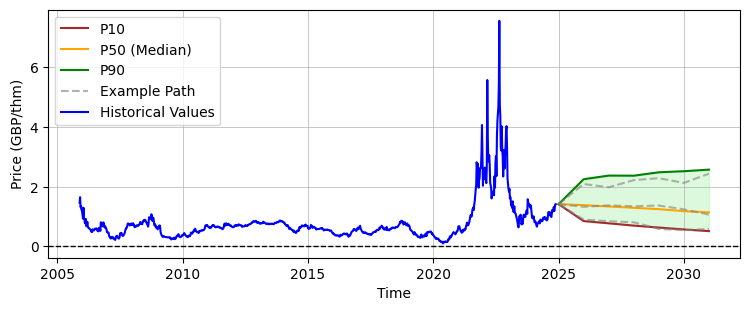

In [6]:
# Load and preprocess historical data
file_path = "Price History_gas_weekly.xlsx - Sheet2.csv"  # Replace with your file path
historical_data = pd.read_csv(file_path)

# Convert "Exchange Date" to datetime
historical_data["Exchange Date"] = pd.to_datetime(historical_data["Exchange Date"], format="%d-%b-%Y")


# Calculate fractional years for each week
historical_data["Year"] = historical_data["Exchange Date"].dt.year
historical_data["Week"] = historical_data["Exchange Date"].dt.isocalendar().week

# Handle cases where Week wraps around (e.g., last days of a year in week 1 of next year)
historical_data["Week"] = historical_data.apply(
    lambda row: row["Week"] + (52 if row["Week"] < 10 and row["Exchange Date"].month == 12 else 0), axis=1
)

# Interpolate fractional years
historical_data["Fractional Year"] = (
    historical_data["Year"] + (historical_data["Week"] - 1) / 52  # Assuming 52 weeks per year
)

# Extract fractional years and corresponding values
historical_years = historical_data["Fractional Year"].values
historical_values = historical_data["Close"].values
all_P_gas = np.array([path.state_variables["P_gas"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years,  # Your simulated years array
    all_P_gas,  # Your simulated state variable paths
    ylabel="Price (GBP/thm)",
    historical_weeks=historical_years,
    historical_values=historical_values,
    save_path="./figures/07_gas_price.png", 
)

In [7]:
max(historical_values)

7.552

In [8]:
min(historical_values)

0.106

### Carbon

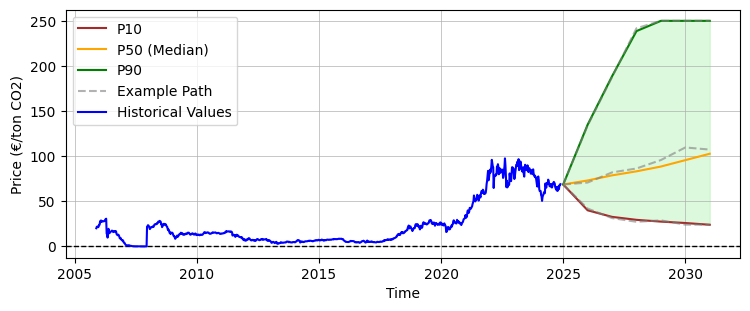

In [9]:
# Load and preprocess historical data
file_path = "Price History_weekly.xlsx - Sheet2.csv"  # Replace with your file path
historical_data = pd.read_csv(file_path)

# Convert "Exchange Date" to datetime
historical_data["Exchange Date"] = pd.to_datetime(historical_data["Exchange Date"], format="%d-%b-%Y")


# Calculate fractional years for each week
historical_data["Year"] = historical_data["Exchange Date"].dt.year
historical_data["Week"] = historical_data["Exchange Date"].dt.isocalendar().week

# Handle cases where Week wraps around (e.g., last days of a year in week 1 of next year)
historical_data["Week"] = historical_data.apply(
    lambda row: row["Week"] + (52 if row["Week"] < 10 and row["Exchange Date"].month == 12 else 0), axis=1
)

# Interpolate fractional years
historical_data["Fractional Year"] = (
    historical_data["Year"] + (historical_data["Week"] - 1) / 52  # Assuming 52 weeks per year
)

# Extract fractional years and corresponding values
historical_years = historical_data["Fractional Year"].values
historical_values = historical_data["Close"].values

all_P_ets = np.array([np.minimum(path.state_variables["P_ets"], 250) for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years,  # Your simulated years array
    all_P_ets,  # Your simulated state variable paths
    ylabel="Price (€/ton CO2)",
    historical_weeks=historical_years,
    historical_values=historical_values,
    save_path="./figures/07_carbon_price.png",
)

## Base Case Results

In [10]:
ppa_price = 1450 # kr/MWh  basert på konsekvensutredning (basert på utsira Nord "high"-case)

In [11]:
npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
npv_fo = fo_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)

In [12]:
print("NPV WC", f"{int(np.mean(npv_wc) / 1e6):,}".replace(",", " "))
print("NPV FO", f"{int(np.mean(npv_fo) / 1e6):,}".replace(",", " "))
print("NPV Net:", f"{int((np.mean(npv_wc) + np.mean(npv_fo)) / 1e6):,}".replace(",", " "))

NPV WC -78
NPV FO 573
NPV Net: 495


### Wind Contractor’s Perspective

In [13]:
r = kwargs["r"]

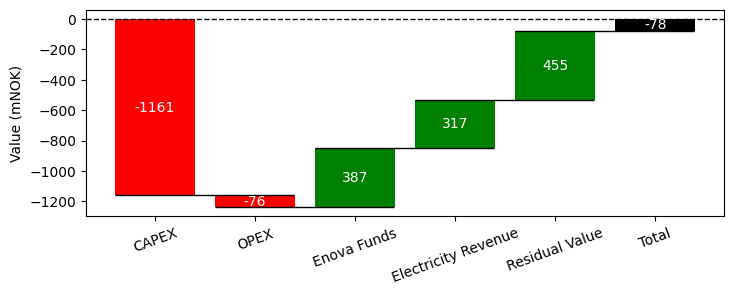

In [14]:
cash_flows = [
    net_present_value(wc_simulation.paths[0].CAPEX_t, r),
    net_present_value(wc_simulation.paths[0].OPEX_t, r),
    net_present_value(wc_simulation.paths[0].CAPEX_support_t, r),
    net_present_value(wc_simulation.paths[0].electricity_revenue_t, r),
    net_present_value(wc_simulation.paths[0].wind_residual_value_t, r),
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "OPEX",
    "Enova Funds",
    "Electricity Revenue",
    "Residual Value"
]

plot_contributors_waterfall(contributors, cash_flows, 
                            save_path="./figures/07_waterfall_wc.png")

In [15]:
# lifetime perspective
electricity_production_t = np.array(
    [0 for i in range(kwargs["t_construction"])] +
    [(kwargs["wind_annual_power_production"]) for i in range(kwargs["LT_turbine"])]
)
opex_t = np.array(
    [0 for i in range(kwargs["t_construction"])] +
    [(-kwargs["OPEX"]) for i in range(kwargs["LT_turbine"])]
)
capex_t = wc_simulation.paths[0].CAPEX_t
enova_t = wc_simulation.paths[0].CAPEX_support_t


In [16]:
# lifetime
(net_present_value(capex_t, r) + net_present_value(opex_t, r)) / net_present_value(electricity_production_t, r)

-1891.5313116415407

In [17]:
# ppa price
-1450

-1450

In [18]:
# w/ enova
(net_present_value(capex_t, r) + net_present_value(opex_t, r) + net_present_value(enova_t,r)) / net_present_value(electricity_production_t, r)

-1376.9087384332856

In [19]:
# ppa price from 2030 onwards
-1200

-1200

### Field Operator Cash Flows

In [20]:
# average price of gas given our assumptions
np.mean([path.state_variables["P_gas"][2:-1] for path in fo_simulation.paths])

1.4455885928948138

In [21]:
electricity_production_t = np.array(
    [0 for i in range(kwargs["t_construction"])] +
    [(kwargs["wind_annual_power_production"]) for i in range(kwargs["LT_field"] - kwargs["t_construction"])]
)

In [22]:
# LCOE of gas
(
    np.mean(np.array([net_present_value(
        path.added_natural_gas_sales_t + path.avoided_co2_allowance_t + path.avoided_co2_tax_t,
        r
    ) for path in fo_simulation.paths]))
     / net_present_value(electricity_production_t, r)
)

4633.525619341469

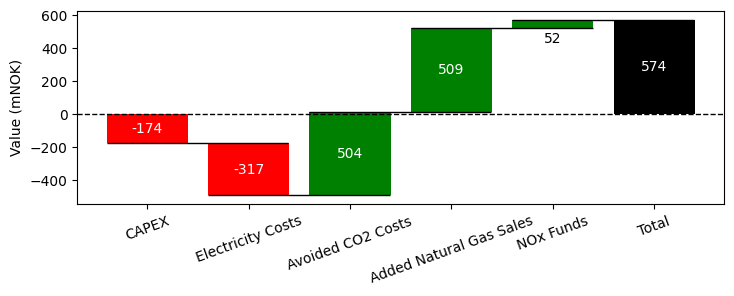

In [23]:
cash_flows = [
    net_present_value(fo_simulation.paths[0].CAPEX_FO_t, r),
    net_present_value(fo_simulation.paths[0].electricity_costs, r),

    np.mean(
        [
            net_present_value(path.avoided_co2_allowance_t + path.avoided_co2_tax_t, r)
            for path in fo_simulation.paths
        ]
    ),
    np.mean(np.array([net_present_value(path.added_natural_gas_sales_t, r) for path in fo_simulation.paths])), 

    net_present_value(fo_simulation.paths[0].government_funding_t, r),
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "Electricity Costs",
    "Avoided CO2 Costs",
    "Added Natural Gas Sales",
    "NOx Funds",
]

plot_contributors_waterfall(contributors, cash_flows, 
                            save_path="./figures/07_waterfall_fo.png")

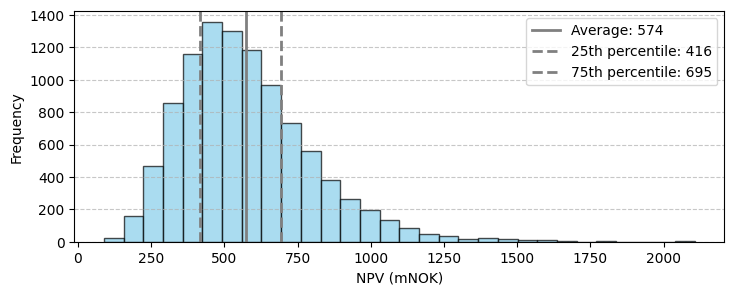

In [24]:
plot_histogram(
    np.array(npv_fo)/10**6, 
    xlabel="NPV (mNOK)",
    percentile_lines=[25, 75],#, 99],
    save_path="./figures/07_npv_histogram_fo.png"
)

In [25]:
np.min(npv_fo) / 10**6

88.7416680407348

In [26]:
np.max(npv_fo) / 10**6

2106.250725589053

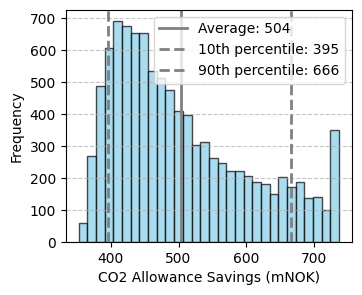

In [27]:
avoided_co2_costs = np.array(
    [
        net_present_value(path.avoided_co2_allowance_t + path.avoided_co2_tax_t, r)
        for path in fo_simulation.paths
    ]
)

plot_histogram(
    avoided_co2_costs/10**6, 
    xlabel="CO2 Allowance Savings (mNOK)",
    width=0.5,
    percentile_lines=[10, 90],
   save_path="./figures/07_npv_contribution_co2_histogram_fo.png"
)

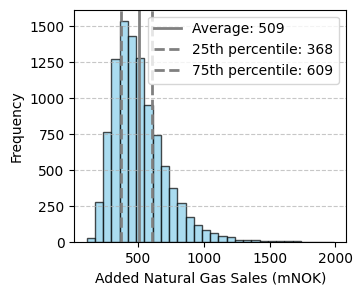

In [28]:
added_natural_gas_sales = np.array(
    [
        net_present_value(path.added_natural_gas_sales_t, r)
        for path in fo_simulation.paths
    ]
)

plot_histogram(
    added_natural_gas_sales/10**6, 
    xlabel="Added Natural Gas Sales (mNOK)",
    width=0.5,
    percentile_lines=[25,75],
    save_path="./figures/07_npv_contribution_gas_histogram_fo.png"
)

In [29]:
class SpecialPathClass(FieldOperatorPath):
    """ This class allows analyzing deterministic price paths"""
    
    def __init__(self, ets, gas) -> None:
        self.ets = ets
        self.gas = gas
        super().__init__()

    def simulate_state_variables(self):
        P_ets_t = self.ets
        P_gas_t = self.gas

        return {"P_ets": P_ets_t, "P_gas": P_gas_t}

In [30]:
tmp = SpecialPathClass(
    np.array([0]*(kwargs['LT_field']+1)),
    np.array([0]*(kwargs['LT_field']+1))
)
tmp.calculate_cash_flows(ppa_price=ppa_price, **kwargs)
tax_contribution_floor = net_present_value(tmp.avoided_co2_tax_t, r)


In [31]:
# tax contribution
tax_contribution_floor / 10**6

343.7473122821342

In [32]:
# min co2 cost
np.min(avoided_co2_costs) / 10**6

352.34686932683144

In [33]:
# max co2 cost
np.max(avoided_co2_costs) / 10**6

737.5463163879335

In [34]:
# min gas contribution
np.min(added_natural_gas_sales) / 10**6

110.75708293147582

In [35]:
# max gas contribution
np.max(added_natural_gas_sales) / 10**6

1987.783934845671

In [36]:
annualization_factor = 1 / (net_present_value(
    (
        [0 for i in range(kwargs["t_construction"])]
        + [1 for i in range(kwargs["t_construction"], kwargs["LT_field"])]
    ),
    r
) * 10**6)

In [37]:
# annualized co2 cost savings
np.mean(avoided_co2_costs) * annualization_factor

159.17541679960257

In [38]:
# annualized gas savings
np.mean(added_natural_gas_sales) * annualization_factor

160.68728213618266

### Net perspective

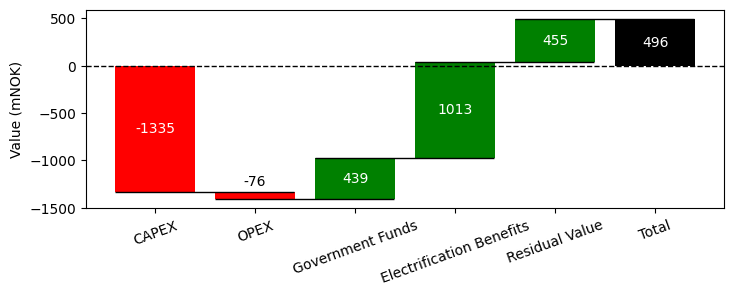

In [39]:
cash_flows = [
    ( # CAPEX
        net_present_value(wc_simulation.paths[0].CAPEX_t, r) 
        + net_present_value(fo_simulation.paths[0].CAPEX_FO_t, r)
    ),
    ( # OPEX
        net_present_value(wc_simulation.paths[0].OPEX_t, r)
    ),
    ( # Gov't funding
        net_present_value(wc_simulation.paths[0].CAPEX_support_t, r)
        + net_present_value(fo_simulation.paths[0].government_funding_t, r)
    ),
    ( # Electrification benefits
        np.mean(
            [
                net_present_value(path.avoided_co2_allowance_t + path.avoided_co2_tax_t, r)
                for path in fo_simulation.paths
            ]
        )
        + np.mean(np.array([net_present_value(path.added_natural_gas_sales_t, r) for path in fo_simulation.paths]))
    ),
    ( # residual value
        net_present_value(wc_simulation.paths[0].wind_residual_value_t, r)
    )
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "OPEX",
    "Government Funds",
    "Electrification Benefits",
    "Residual Value"
]


plot_contributors_waterfall(contributors, cash_flows, 
                            save_path="./figures/07_waterfall_net.png")

In [40]:
electrification_benefits = np.array([
    net_present_value(path.avoided_co2_allowance_t + path.avoided_co2_tax_t + path.added_natural_gas_sales_t, r)
    for path in fo_simulation.paths
])

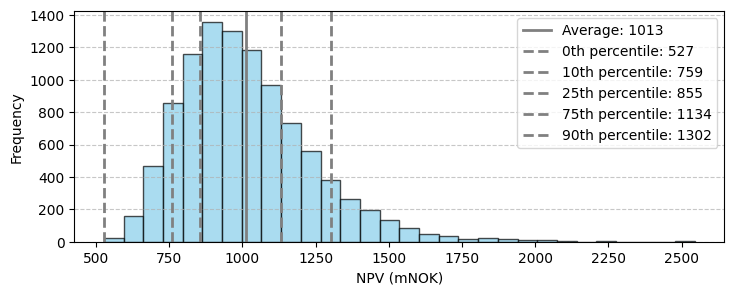

In [41]:
plot_histogram(
    electrification_benefits/10**6, 
    xlabel="NPV (mNOK)",
    percentile_lines=[0, 10, 25, 75, 90],#, 99],
    # save_path="./figures/07_npv_histogram_fo.png"
)

# Sensitivity Analyses

In [42]:
def get_impacts(parameter, val):
    if val==None:
        return npv_wc[0]/10**6, npv_fo/10**6
        
    ppa_price_loc = ppa_price
    kwargs_loc = kwargs.copy()
    fo_simulation_loc = fo_simulation

    if parameter == "ppa_price":
        ppa_price_loc = val
    if parameter in kwargs:
        kwargs_loc[parameter] = val
        
        # MWh
        kwargs_loc["wind_annual_power_production"] = (
            kwargs_loc["wind_power_rating"] * kwargs_loc["wind_capacity_factor"] * 24 * 365.25
        )

        # NG_const Sm3
        kwargs_loc["gas_burned_without_owf"] = (
            kwargs_loc["wind_annual_power_production"] * 3.6 * 10**3 / (
                kwargs_loc["gas_efficiency_factor"] * 40  # HHV = 40 MJ/Sm3
            )
        )

        # tax ceiling
        kwargs_loc["co2_tax_ceiling"] = kwargs_loc["end_tax"] / kwargs_loc["gas_CO2_emissions_factor"]

    if ((parameter in gas_schwartz_smith_params) or (parameter in carbon_gbm_params)
            or (parameter == "LT_field") or (parameter == "init_gas_price")
    ):
        gas_schwartz_smith_params_loc = gas_schwartz_smith_params.copy()
        carbon_gbm_params_loc = carbon_gbm_params.copy()

        if (parameter in carbon_gbm_params):
            carbon_gbm_params_loc[parameter] = val
        if (parameter in gas_schwartz_smith_params):
            gas_schwartz_smith_params_loc[parameter] = val
        if (parameter == "init_gas_price"):
            gas_schwartz_smith_params_loc["xi_0"] = np.log(val)

        if (parameter == "LT_field"):
            carbon_gbm_params_loc["period"] = kwargs_loc["LT_field"] + 1
            gas_schwartz_smith_params_loc["period"] = kwargs_loc["LT_field"] + 1

        fo_simulation_loc = MonteCarlo(
            lambda : FieldOperatorPath(carbon_gbm_params_loc, gas_schwartz_smith_params_loc), 
            W
        )
    

    wc_npv = (
        wc_simulation.calculate_all_cash_flows(ppa_price=ppa_price_loc, **kwargs_loc)[0]
    ) / 10**6
        
    fo_npv = fo_simulation_loc.calculate_all_cash_flows(ppa_price=ppa_price_loc, **kwargs_loc) / 10**6

    return wc_npv, fo_npv


In [43]:
def get_thresholds(parameter, low, high):
    try:
        threshold_wc = brentq(lambda val : get_impacts(parameter, val)[0], low, high)
    except:
        threshold_wc = None
    try:
        threshold_fo = brentq(lambda val : np.mean(get_impacts(parameter, val)[1]), low, high)
    except:
        threshold_fo = None
    try:
        def objective(val):
            impact = get_impacts(parameter, val)
            return impact[0] + np.mean(impact[1])
        threshold_net = brentq(objective, low, high)
    except:
        threshold_net = None

    return threshold_wc, threshold_fo, threshold_net

## PPA vs. NPV

In [44]:
ppa_threshold = get_thresholds("ppa_price", 1000, 5000)[0]

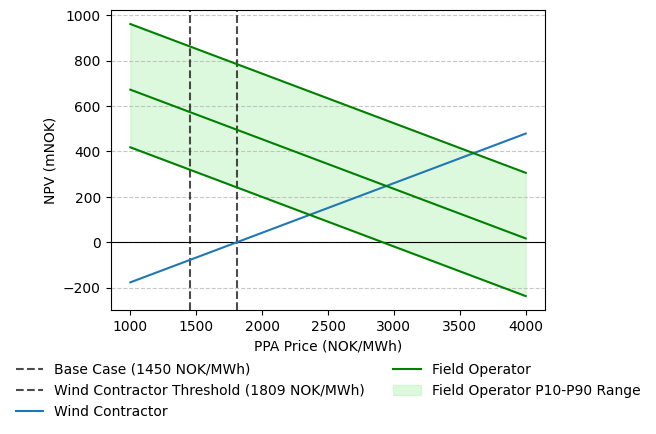

In [45]:
# Define PPA prices
parameter = "ppa_price"
values = [1000, 1450, 4000]

# Use the updated function to get the NPVs
impacts = [get_impacts(parameter, value) for value in values]

wc_npvs = [impact[0] for impact in impacts]
fo_npvs = [np.mean(impact[1]) for impact in impacts]
fo_npvs_10 = [np.percentile(impact[1], 10) for impact in impacts]
fo_npvs_90 = [np.percentile(impact[1], 90) for impact in impacts]

# Configure rcParams for consistent styling
plt.rcParams.update({
    'font.size': 10,  # Set default font size for all text
    'axes.titlesize': 10,  # Font size for titles
    'axes.labelsize': 10,  # Font size for axis labels
    'xtick.labelsize': 10,  # Font size for x-ticks
    'ytick.labelsize': 10,  # Font size for y-ticks
    'legend.fontsize': 10,  # Font size for legend
    'figure.figsize': (8.27 * 0.75, 11.69 * 0.9 * (6 / 8.27) / 2*1.2)  # A4 page with 0.9 linewidth
})

# Create a line graph
plt.figure()

plt.axhline(0, color="black", lw=0.8)

# Add a vertical line for the base case PPA price
plt.axvline(
    1450,  # Adjust this value to match your base case
    linestyle='--',
    alpha=0.7,
    color='black',
    label='Base Case (1450 NOK/MWh)'
)

# Add a vertical line for the base case PPA price
plt.axvline(
    ppa_threshold,  # Adjust this value to match your base case
    # ymax=0,
    linestyle='--',
    alpha=0.7,
    color='black',
    label=f'Wind Contractor Threshold ({ppa_threshold:.0f} NOK/MWh)'
)

# Plot the NPVs for WC and FO
plt.plot(values, wc_npvs, marker='', label='Wind Contractor')
plt.plot(values, fo_npvs, marker='', label='Field Operator',color = "green")
plt.plot(values, fo_npvs_10, marker='', color = "green")
plt.plot(values, fo_npvs_90, marker='', color = "green")

# Add shading between P10 and P90
plt.fill_between(values, fo_npvs_10, fo_npvs_90, color="lightgreen", alpha=0.3, label='Field Operator P10-P90 Range')

# Add labels, title, and legend
plt.xlabel('PPA Price (NOK/MWh)')
plt.ylabel('NPV (mNOK)')
# plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(0.5, -0.27), loc='center', ncol=2, frameon=False)


# Add grid and save the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/07_ppa_sensitivity.png", dpi=300, bbox_inches="tight")
plt.show()


In [46]:
get_thresholds("ppa_price", 1000, 5000)

(1808.648396039061, 4076.595337168626, None)

## Sensitivity tornado plot

In [47]:
parameter_ranges = {
    "wind_capacity_factor": [0.42, 0.525, 0.63],
    "CAPEX_WC": [700 * 10**6, 1200 * 10**6, 1700 * 10**6],
    "gas_efficiency_factor": [0.24, 0.30, 0.36],
    "LT_field": [None, 6, 8],
    "r": [0.056, 0.07, 0.084],
    "OPEX": [9.6 * 10**6, 24 * 10**6, 36 * 10**6],
    "end_tax": [5.32, 6.65, 7.98],
    "sigma_chi": [0.544, 0.68, 0.816],
    "sigma_xi": [0.192, 0.24, 0.288],
    "mu_xi": [-0.032, -0.04, -0.048],
    "init_gas_price": [1.13, 1.42, 1.70],
    "sigma": [0.401, 0.472, 0.588],
    "p_0": [54.92, 68.65, 82.38],
    "mu": [None, 0.178, 0.395],
    "carbon_price_ceiling": [200, 250, 300],
}
parameter_units = {
    "wind_capacity_factor": "%",
    "CAPEX_WC": "mNOK",
    "gas_efficiency_factor": "%",
    "LT_field": "years",
    "r": "%",
    "OPEX": "mNOK",
    "end_tax": "NOK/Sm3",
    "sigma_chi": "%",
    "sigma_xi": "%",
    "mu_xi": "%",
    "init_gas_price": "GBP/thrm",
    "sigma": "%",
    "p_0": "EUR/tCO2",
    "mu": "%",
    "carbon_price_ceiling": "EUR/tCO2",
}
parameter_display_names = {
    "wind_capacity_factor": "Wind Capacity Factor",
    "CAPEX_WC": "Wind Contractor CAPEX",
    "gas_efficiency_factor": "Gas Efficiency Factor",
    "LT_field": "Field Lifetime",
    "r": "Discount Rate",
    "OPEX": "OPEX",
    "end_tax": "2030 Carbon Tax",
    "sigma_chi": "Short-term Gas Price Volatility",
    "sigma_xi": "Long-term Gas Price Volatility",
    "mu_xi": "Gas Price Drift",
    "init_gas_price": "Gas Price Level",
    "sigma": "CO₂ Price Volatility",
    "p_0": "CO₂ Price Level",
    "mu": "CO₂ Price Drift",
    "carbon_price_ceiling": "CO₂ Price Ceiling",
}


In [48]:
# Define the baseline NPV
wc_npv, fo_npv = get_impacts("baseline", None)
baseline_npv = wc_npv + np.mean(fo_npv)

In [49]:
# Calculate low and high impacts for each parameter
results = []
for param, (low, baseline, high) in parameter_ranges.items():
    # Low value
    wc_npv, fo_npv = get_impacts(param, low)
    low_npv = wc_npv + np.mean(fo_npv)

    # High value
    wc_npv, fo_npv = get_impacts(param, high)
    high_npv = wc_npv + np.mean(fo_npv)

    results.append((param, min(low_npv, high_npv), max(low_npv, high_npv)))

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Parameter", "Low", "High"])
df["Effect"] = df["High"] - df["Low"]
impacts = df.sort_values("Effect", ascending=True, key=abs)


<lambda> Simulation complete at 365 ms
<lambda> Simulation complete at 312 ms
<lambda> Simulation complete at 321 ms
<lambda> Simulation complete at 285 ms
<lambda> Simulation complete at 287 ms
<lambda> Simulation complete at 285 ms
<lambda> Simulation complete at 317 ms
<lambda> Simulation complete at 299 ms
<lambda> Simulation complete at 297 ms
<lambda> Simulation complete at 293 ms
<lambda> Simulation complete at 322 ms
<lambda> Simulation complete at 289 ms
<lambda> Simulation complete at 292 ms
<lambda> Simulation complete at 324 ms


In [50]:
def get_display_text(value, unit):
    """
    Formats the display text for a value based on its unit.

    Args:
        value (float): The numeric value to format.
        unit (str): The unit associated with the value.

    Returns:
        str: A formatted string representing the value with its unit.
    """
    if value is None:
        return "N/A"  # Return "N/A" for None values
    if unit == "%":
        # For percentages, multiply by 100 and append "%"
        return f"{value * 100:.1f}%"
    elif unit == "mNOK":
        # For mNOK, divide by 10^6 and use zero decimals
        return f"{value / 10**6:.0f} mNOK"
    elif unit == "EUR/tCO2":
        return f"{value:.0f} {unit}"
    elif unit in ["NOK/Sm3", "GBP/thrm"]:
        # For prices, use two decimals and append the unit
        return f"{value:.2f} {unit}"
    elif unit == "years":
        # For years, return the value as an integer
        return f"{int(value)} years"
    else:
        # Default case: return the value with no formatting
        return f"{value} {unit}"

In [51]:
results = []
for param in impacts.Parameter:
    # Extract low, baseline, and high values from parameter_ranges
    low, baseline, high = parameter_ranges[param]

    # Default to baseline if low or high is None
    if low is None:
        low = baseline
    if high is None:
        high = baseline

    # Calculate percentage changes
    low_change = ((low - baseline) / baseline) * 100
    high_change = ((high - baseline) / baseline) * 100

    # Format labels using get_display_text
    low_label = get_display_text(low, parameter_units[param])
    baseline_label = get_display_text(baseline, parameter_units[param])
    high_label = get_display_text(high, parameter_units[param])

    # Append results
    results.append((param, parameter_display_names[param], low_change, high_change, low_label, baseline_label, high_label))

# Convert to DataFrame
pct_change = pd.DataFrame(
    results,
    columns=["Parameter", "Display Name", "Low", "High", "Low Label", "Baseline", "High Label"]
)


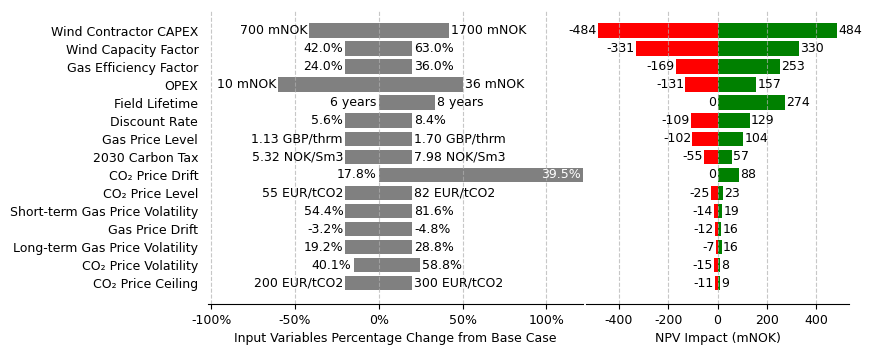

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Configuration for consistent styling
plt.rcParams.update({
    'font.size': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.figsize': (8.27 * 1, 11.69 * 0.9 * (6 / 8.27) / 2)  # A4 page with scaling
})

# Create subplots for side-by-side tornado plots
fig, axes = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 0.7], 'wspace': 0.01})

### Left Plot: Input Variables Percentage Change
df = pct_change
baseline_value = 0
xlabel_left = "Input Variables Percentage Change from Base Case"

xmin = min(df["Low"] - baseline_value)
xmax = max(df["High"] - baseline_value)
y_positions = range(len(df))

axes[0].set_xlabel(xlabel_left)

# Iterate through rows and plot bars
for i, (index, row) in enumerate(df.iterrows()):
    # Plot bars for low and high
    axes[0].barh(y_positions[i], row["High"] - baseline_value, color="gray", edgecolor=None)
    axes[0].barh(y_positions[i], row["Low"] - baseline_value, color="gray", edgecolor=None)

    # Add text annotations
    axes[0].text(
        row["Low"] - baseline_value - 0.01 * xmax,
        y_positions[i],
        f"{row['Low Label']}",
        va="center",
        ha="right",
        color="black"
    )
    small_bar = (row["High"] - baseline_value < 0.9*xmax)
    axes[0].text(
        (
            row["High"]
            + (0.01*xmax if small_bar else (-0.01*xmax))
        ),
        y_positions[i],
        f"{(row['High Label'])}",
        va="center",
        ha="left" if small_bar else "right",
        color="black" if small_bar else "white"
    )
    # axes[0].text(
    #     row["High"] - baseline_value + 0.01 * xmax,
    #     y_positions[i],
    #     f"{row['High Label']}",
    #     va="center",
    #     ha="left",
    #     color="black"
    # )

# Customize x-axis
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))
axes[0].set_xticks(np.arange(-100, 101, 50))
axes[0].grid(axis="x", linestyle="--", alpha=0.7)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_xlim(xmin*1.7, xmax)

axes[0].set_yticks(y_positions)
axes[0].tick_params(axis='y', left=False, labelleft=True)
axes[0].set_yticklabels(df["Display Name"])

### Right Plot: NPV Impact
df = impacts
baseline_value = baseline_npv
xlabel_right = "NPV Impact (mNOK)"

xmin = min(df["Low"] - baseline_value)
xmax = max(df["High"] - baseline_value)
y_positions = range(len(df))

axes[1].set_xlabel(xlabel_right)

# Draw baseline line
# axes[1].axvline(0, color="black", linestyle="-", linewidth=1)

# Iterate through rows and plot bars
for i, (index, row) in enumerate(df.iterrows()):
    # Plot bars for low and high
    axes[1].barh(y_positions[i], row["High"] - baseline_value, color="green", edgecolor=None)
    axes[1].barh(y_positions[i], row["Low"] - baseline_value, color="red", edgecolor=None)

    # Add text annotations
    axes[1].text(
        row["Low"] - baseline_value - 0.01 * xmax,
        y_positions[i],
        f"{(row['Low'] - baseline_value):.0f}",
        va="center",
        ha="right",
        color="black"
    )
    axes[1].text(
        row["High"] - baseline_value + 0.01 * xmax,
        y_positions[i],
        f"{(row['High'] - baseline_value):.0f}",
        va="center",
        ha="left",
        color="black"
    )

# Customize x-axis
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))
axes[1].grid(axis="x", linestyle="--", alpha=0.7)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# Hide y-axis ticks on the right plot
axes[1].tick_params(axis='y', left=False, labelleft=False)

# Adjust layout
# plt.tight_layout()

# Save or show the plot
save_path = "./figures/07_tornado_combined.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()


***

In [55]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven wind_residual_value  Levels", 
    xlabel="wind_residual_value (mNOK)"
)

NameError: name 'plot_breakeven_histogram' is not defined

### CAPEX vs Residual Value

In [ ]:
resid_levels_50 = []
resid_levels_90 = []
capex_levels = np.arange(2000, 4001, 2000) * 10 ** 6
for CAPEX in capex_levels:
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX

    zero_levels = []

    for path in fo_simulation.paths:
        def objective(wind_residual_value):
            kwargs_copy2 = kwargs_copy.copy()
            kwargs_copy2["wind_residual_value"] = wind_residual_value
            npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
            npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
            return (npv_wc + npv_fo)

        zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)
    
    resid_levels_50.append(np.median(zero_levels))
    resid_levels_90.append(np.quantile(zero_levels, 0.9))

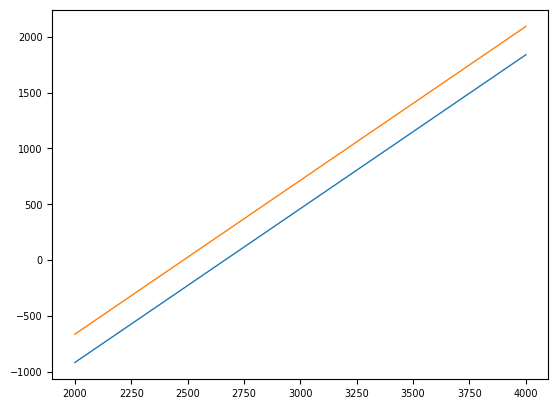

In [ ]:
plt.plot(capex_levels/(10**6), resid_levels_50)
plt.plot(capex_levels/(10**6), resid_levels_90)

## Scenarios

### Low gas scenario

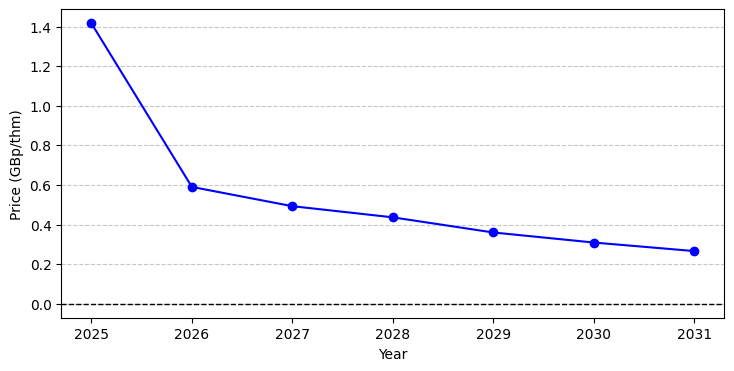

In [ ]:
gas_1 = np.percentile(all_P_gas, 1, axis=0) 

low_gas_scenario = SpecialPathClass(ets_50, gas_1)
low_gas_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

plot_timeline_line(
    years, 
    gas_1, 
    ylabel="Price (GBP/thm)", 
    save_path="./figures/07_low_gas_scenario_gas_price.png"
)

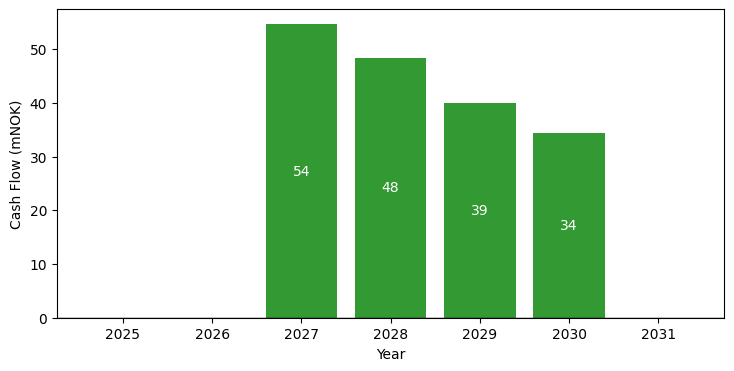

In [ ]:
plot_timeline_bar(
    years, 
    low_gas_scenario.added_natural_gas_sales_t/10**6
)

In [ ]:
np.mean(
    low_gas_scenario.added_natural_gas_sales_t[2:6]
)


44336758.4451048

### Low tax scenario

In [ ]:
low_tax_scenario = SpecialPathClass(np.array([0]*7), gas_50)
low_tax_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

base_case_tax = low_tax_scenario.co2_tax_rate

In [ ]:

low_tax_scenario = SpecialPathClass(np.array([0]*7), gas_50)
tmp = kwargs['end_tax']
kwargs['end_tax'] = 4.80
low_tax_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

low_tax_scenario_tax = low_tax_scenario.co2_tax_rate

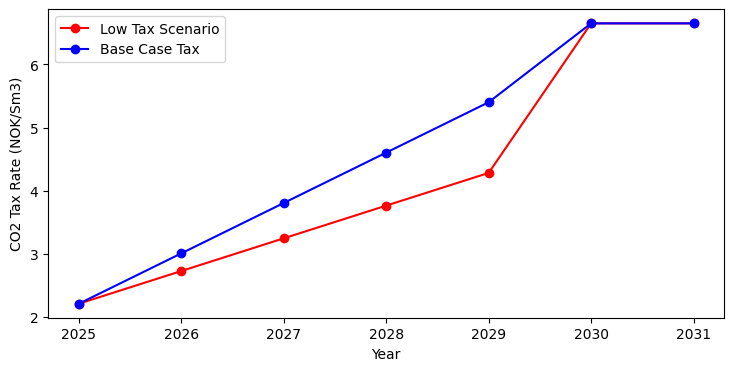

In [ ]:
plt.figure()
plt.plot(years, low_tax_scenario_tax, marker='o', color='red', label="Low Tax Scenario")
plt.plot(years, base_case_tax, marker='o', color='blue', label="Base Case Tax")
plt.xlabel("Year")
plt.ylabel("CO2 Tax Rate (NOK/Sm3)")
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
net_present_value(low_tax_scenario.avoided_co2_tax_t, r)

288213900.1007452

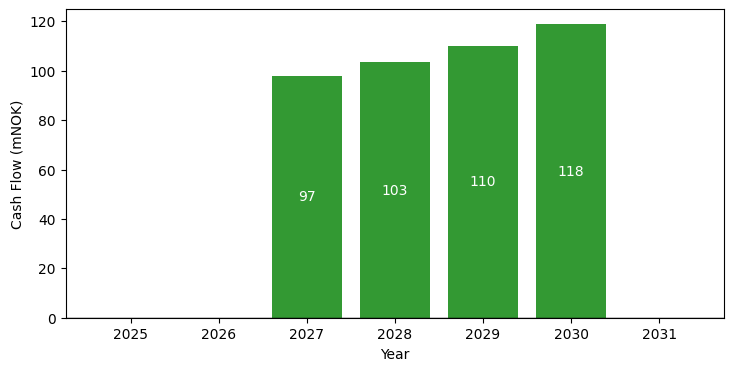

In [ ]:
low_tax_scenario = SpecialPathClass(ets_50, gas_50)
low_tax_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

plot_timeline_bar(
    years, 
    (low_tax_scenario.avoided_co2_allowance_t + low_tax_scenario.avoided_co2_allowance_t)/10**6
)

In [ ]:
low_tax_scenario.state_variables["P_ets"]

array([ 68.65      ,  73.12186467,  78.75366012,  83.23038037,
        88.53872007,  95.63424897, 102.73366583])

In [ ]:
low_tax_scenario.avoided_co2_tax_t

array([       0.        ,        0.        , 67223605.05      ,
       77951216.7       , 88678828.35      , 78294957.95022966,
              0.        ])

In [ ]:
low_tax_scenario.avoided_co2_allowance_t

array([       0.        ,        0.        , 48960848.05386568,
       51744007.83780447, 55044182.24713444, 59455445.31227034,
              0.        ])

In [ ]:
kwargs['end_tax'] = tmp

***
***
# Junkyard
***


### Net Project

In [ ]:
zero_levels = []

num_npv_negative = 0

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        print(npv_wc, npv_fo, npv_wc + npv_fo)
        return (npv_wc - npv_fo)
    
    zero_levels.append(brentq(objective, ppa_low, ppa_high))
    # except ValueError:
    #     num_npv_negative += 1
    #     continue


-16009157.581164658 917523999.0822761 901514841.5011115
22550409420.936367 -20034575223.54747 2515834197.388897
468072126.3093592 468072126.3093591 936144252.6187183
468072126.30935884 468072126.3093594 936144252.6187181
-16009157.581164658 1023869004.8269771 1007859847.2458124
22550409420.936367 -19928230217.802765 2622179203.133602
523217063.10007197 523217063.1000719 1046434126.2001438
523217063.1000714 523217063.1000725 1046434126.2001438
-16009157.581164658 951207459.0215548 935198301.4403901
22550409420.936367 -20000891763.60819 2549517657.3281784
485538600.2282492 485538600.2282492 971077200.4564984
-16009157.581164658 763176822.4106419 747167664.8294773
22550409420.936367 -20188922400.2191 2361487020.717266
388035783.82407653 388035783.8240765 776071567.6481531
388035783.82407606 388035783.8240769 776071567.648153
-16009157.581164658 890722371.9520608 874713214.3708961
22550409420.936367 -20061376850.67768 2489032570.258686
454174209.5841291 454174209.5841288 908348419.168258
4

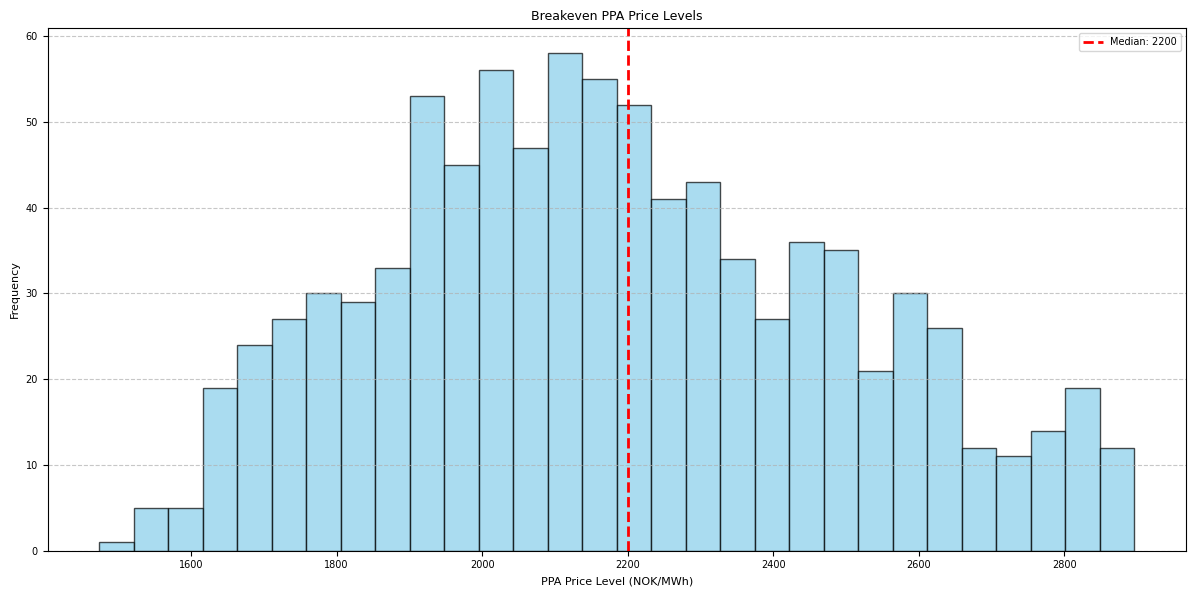

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)

Annual means to be used for discussion part

In [ ]:
np.mean(special_path.added_natural_gas_sales_t[special_path.added_natural_gas_sales_t != 0]) / 10**6

140.40647120988623

In [ ]:
np.mean(special_path.avoided_co2_tax_t[special_path.avoided_co2_tax_t != 0]) / 10**6

91.08424726255741

In [ ]:
np.mean(special_path.avoided_co2_allowance_t[special_path.avoided_co2_allowance_t != 0]) / 10**6

53.801120862768734

In [ ]:
special_path = SpecialPathClass(ets_50, gas_50)
special_path.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

464673289.3392784